In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
from torchvision import datasets
data_path = '../data-unversioned/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 63921532.73it/s]


Extracting ../data-unversioned/cifar-10-python.tar.gz to ../data-unversioned/
Files already downloaded and verified


In [ ]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [ ]:
from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

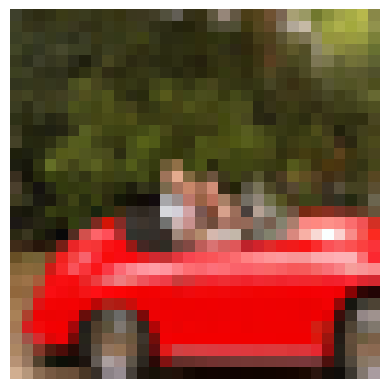

In [ ]:
import matplotlib.pyplot as plt

# Plot an example before processing
plt.axis("off")
img_t, _ = tensor_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0)) # From C x W x H to W x H x C


### Data Normalization

In [ ]:
# 50000 images concatenated into one stack
import torch

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape


torch.Size([3, 32, 32, 50000])

In [ ]:
# Computing means and stds per channel
means = imgs.view(3, -1).mean(dim=1) # 3x(1024*50000) (each is a mean of 1024*50000 pixel values)
stds = imgs.view(3, -1).std(dim=1)

# Normalization (GAUSSIAN mean=0, std=1)
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
)

In [ ]:
img_t.max()

tensor(1.)

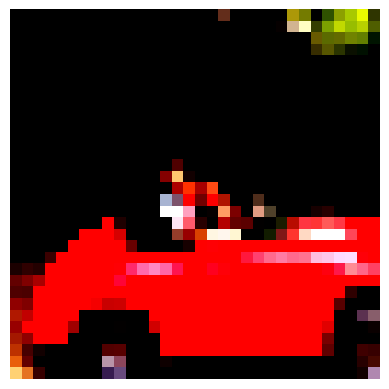

In [ ]:
# Plotting after normalization
plt.axis("off")
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0)) # From C x W x H to W x H x C

# Birds and Airplanes Classification

In [ ]:
# Filtering airplane and bird data from the CIFAR10

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
  for img, label in transformed_cifar10
  if label in label_map.keys()]

cifar2_val = [(img, label_map[label])
  for img, label in transformed_cifar10
  if label in label_map.keys()]

# DataLoader for minibatch
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)


# A Conv Model
Why CrossEntropyLoss over RMSELoss. Softmax introduces flatness to the results and the curve of RMSE is too shallow to counteract it. (LogSoftmax + Negative Log Likelihood = CrossEntropy)

### Training and Validation functions

In [21]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  model.train()

  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print(f"{datetime.datetime.now()} Epoch {epoch}, Training Loss: {loss_train / len(train_loader)}")


def validate(model, train_loader, val_loader):
  model.eval()

  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy {}: {:.2f}".format(name, correct/total))

### Model Architechture

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8) # batch_size, flattened(C*H*W)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [26]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2024-08-22 09:46:45.877651 Epoch 1, Training Loss: 0.5823675619948442
2024-08-22 09:47:27.955143 Epoch 10, Training Loss: 0.33293871135468694


# Deep Residual Connections

In [28]:
class ResBlock(nn.Module):
  def __init__(self, n_channels):
    super(ResBlock, self).__init__()

    self.conv = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1, bias=False) # BatchNorm cancels out the effet of bias, so no need
    self.batch_norm = nn.BatchNorm2d(num_features=n_channels)

    # Weight initializations
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5) # normal with std=0.5
    torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [30]:
class ResNetDeep(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=100):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(
        *(n_blocks * [ResBlock(n_channels=n_chans1)])
    )
    self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out
